### Building a Customer Support Agent using LangGraph

This tutorial demonstrates how to create an intelligent customer support agent using LangGraph, a powerful tool for building complex language model workflows. The agent is designed to categorize customer 

### Import Necessary Libraries

In [ ]:
pip install langgraph langchain_core langchain_groq

In [2]:
from typing import Dict, TypedDict, Optional
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os

# Load environment variables and set OpenAI API key
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')

/Users/cameron/Documents/ITCS_5010_Gen_AI_TA/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define State Structure

In [3]:
class State(TypedDict):
    query: str
    category: Optional[str]
    sentiment: Optional[str]
    response: Optional[str]
    approved: Optional[bool]
    feedback: Optional[str]  # Explicitly declared
    refinement_attempts: int

### Define Node Functions

In [4]:
model_name = "llama-3.1-8b-instant"

def categorize(state: State) -> State:
    """Categorize the customer query into Technical, Billing, or General."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )
    chain = prompt | ChatGroq(model=model_name, temperature=0)
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}


def analyze_sentiment(state: State) -> State:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | ChatGroq(model=model_name, temperature=0)
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}


def handle_technical(state: State) -> State:
    """Provide a technical support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | ChatGroq(model=model_name, temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}


def handle_billing(state: State) -> State:
    """Provide a billing support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | ChatGroq(model=model_name, temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}


def handle_general(state: State) -> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | ChatGroq(model=model_name, temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}


# human approval with feedback collection
def human_approval(state: State) -> State:
    """Collect human decision and feedback with default values."""
    print(f"\n*** Human Review ***\nQuery: {state['query']}\nResponse: {state['response']}\n")
    
    decision = input("Approve response? (y/n): ").lower().strip()
    feedback = input("Provide feedback (press enter to skip): ") if decision == 'n' else ""
    
    return {
        "approved": decision == "y",
        "feedback": feedback  # Always included, empty string if approved
    }


# response refinement function
def refine_response(state: State) -> State:
    """Improve response using feedback with defensive key checks."""
    prompt = ChatPromptTemplate.from_template(
        "Improve this response using human feedback:\n"
        "Original Query: {query}\n"
        "Initial Response: {response}\n"
        "Feedback: {feedback}\n"
        "Revised Response:"
    )
    
    chain = prompt | ChatGroq(model=model_name, temperature=0.3)
    
    refined = chain.invoke({
        "query": state.get("query", ""),
        "response": state.get("response", ""),
        "feedback": state.get("feedback", "")  
    }).content
    
    return {
        "response": refined,
        "refinement_attempts": state.get("refinement_attempts", 0) + 1
    }


def escalate(state: State) -> State:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}


def route_query(state: State) -> str:
    """Route the query based on its sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"


# approval routing logic
def route_approval(state: State) -> str:
    """Decide next step based on approval and attempts."""
    if state["approved"]:
        return "approve"
        
    attempts = state.get("refinement_attempts", 0)
    return "escalate" if attempts >= 1 else "refine"


### Create and Configure the Graph

In [5]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)
workflow.add_node("human_approval", human_approval)
workflow.add_node("refine_response", refine_response)

# Set up main flow
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)

# Connect handlers to human approval
workflow.add_edge("handle_technical", "human_approval")
workflow.add_edge("handle_billing", "human_approval")
workflow.add_edge("handle_general", "human_approval")

# Approval routing
workflow.add_conditional_edges(
    "human_approval",
    route_approval,
    {
        "approve": END,
        "refine": "refine_response",
        "escalate": "escalate"
    }
)

# Refinement loop
workflow.add_edge("refine_response", "human_approval")

# Connect escalation directly to end
workflow.add_edge("escalate", END)

# Set entry point
workflow.set_entry_point("categorize")

app = workflow.compile()

### Visualize the Graph

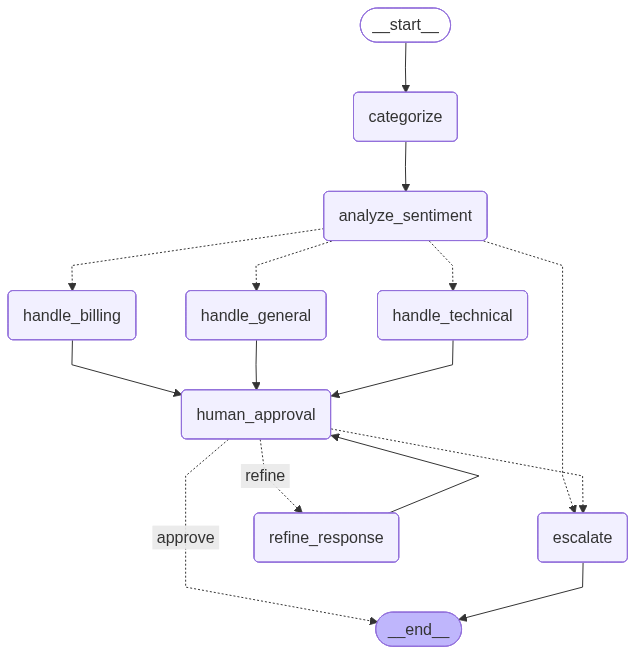

In [6]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run the Application

In [ ]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a query through the workflow with human interaction support."""
    
    # Initialize with empty defaults
    results = app.invoke({"query": query})
    
    # Safe extraction with fallbacks
    return {
        "query": query,
        "category": results.get("category", "Uncategorized"),
        "sentiment": results.get("sentiment", "Neutral"),
        "response": results.get("response", "No response generated"),
        "status": "Escalated" if "escalate" in results else "Completed"
    }

### Test the Agent

In [9]:
# escalate
query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


*** Human Review ***
Query: My internet connection keeps dropping. Can you help?
Response: I'd be happy to help you troubleshoot the issue with your internet connection dropping. Here are some general steps you can try:

1. **Restart your router**: This is often the simplest solution, but it can be effective. Unplug your router from the power source, wait for 30 seconds, and then plug it back in. This will reset your router and may resolve any temporary issues.
2. **Check your cables**: Make sure all cables are securely connected to your router, modem, and any other devices. Try swapping out any damaged or loose cables.
3. **Check your internet service provider (ISP)**: If you're experiencing outages in your area, it may be a problem with your ISP. You can check their website or social media for any updates on outages in your area.
4. **Check for physical obstructions**: Make sure there are no physical obstructions between your router and any devices that are experiencing connectivity

In [11]:
# handle_technical
query = "I need help creating an OpenAI account"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


*** Human Review ***
Query: I need help creating an OpenAI account
Response: I'd be happy to help you create an OpenAI account. 

To get started, you can follow these general steps:

1. **Visit the OpenAI website**: Go to [www.openai.com](http://www.openai.com) and click on the "Sign up" button.
2. **Choose your account type**: Select the type of account you want to create, such as a personal or business account.
3. **Enter your email address**: Provide a valid email address that you'll use to log in to your account.
4. **Create a password**: Choose a strong and unique password for your account.
5. **Verify your email address**: OpenAI will send a verification email to the email address you provided. Click on the verification link to confirm your email address.
6. **Set up your account**: Fill out the required information, such as your name and location.
7. **Review and agree to the terms**: Read and agree to OpenAI's terms of service and privacy policy.

If you encounter any issues d

In [12]:
# handle_billing
query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


*** Human Review ***
Query: where can i find my receipt?
Response: If you're having trouble finding your receipt, here are a few suggestions that might help:

1. **Check your email**: Many businesses send receipts via email after a purchase. Check your inbox and spam folder to see if you received a digital copy of your receipt.
2. **Check your wallet or purse**: It's possible that you might have misplaced your receipt in your wallet or purse. Take a look through your belongings to see if it's there.
3. **Check your bank statement**: If you made a purchase using a credit or debit card, you can check your bank statement to see if the transaction is listed. This might give you an idea of the date and amount of the purchase.
4. **Contact the business**: If you're still unable to find your receipt, you can contact the business where you made the purchase. They may be able to provide you with a copy of your receipt or help you locate it.
5. **Check online account**: If you have an online ac

In [13]:
# handle_general
query = "What are your business hours?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


*** Human Review ***
Query: What are your business hours?
Response: Our business hours are Monday through Friday, 9:00 AM to 5:00 PM EST. We are closed on weekends and major holidays. If you have any urgent matters or need assistance outside of these hours, please feel free to reach out to us via email or our contact form, and we will respond as soon as possible.

Query: What are your business hours?
Category: I would categorize the customer query as "General". This is because the query is asking for general information about the business, specifically its operating hours, rather than a technical or billing-related question.
Sentiment: Neutral 

This query is a factual question and does not express any emotion or opinion. It is a typical customer inquiry seeking information about the business's operating hours.
Response: Our business hours are Monday through Friday, 9:00 AM to 5:00 PM EST. We are closed on weekends and major holidays. If you have any urgent matters or need assistance 